# Predicting Solar Energy Production with Machine Learning

In [1]:
import pyspark
from pyspark import SparkConf
from pyspark import SparkContext
from pyspark.sql import SQLContext
import matplotlib
import matplotlib.pyplot as plt
from pyspark.sql import Row
from pyspark.sql.functions import UserDefinedFunction
from pyspark.sql.types import *
import atexit
from numpy import array
import numpy as np
import datetime
import pixiedust

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20190902090013-0000
KERNEL_ID = 5ec4b92b-16eb-452e-a46d-7862fc3b4b0b
Pixiedust database opened successfully
Table VERSION_TRACKER created successfully
Table METRICS_TRACKER created successfully

Share anonymous install statistics? (opt-out instructions)

PixieDust will record metadata on its environment the next time the package is installed or updated. The data is anonymized and aggregated to help plan for future releases, and records only the following values:

{
   "data_sent": currentDate,
   "runtime": "python",
   "application_version": currentPixiedustVersion,
   "space_id": nonIdentifyingUniqueId,
   "config": {
       "repository_id": "https://github.com/ibm-watson-data-lab/pixiedust",
       "target_runtimes": ["Data Science Experience"],
       "event_id": "web",
       "event_organizer": "dev-journeys"
   }
}
You can opt out by calling pixiedust.optOut() in a new cell.


Pixiedust runtime updated. Please restart kernel
Table SPARK_PACKAGES created successfully
Table USER_PREFERENCES created successfully
Table service_connections created successfully


In [2]:
# The code was removed by Watson Studio for sharing.

In [3]:
#df_data_1.count()

In [4]:
df_data_1.cache() # Cache data for faster reuse

DataFrame[Data Provider: string, System ID (from Data Provider): string, System ID (Tracking the Sun): string, Installation Date: string, System Size: string, Total Installed Price: string, Appraised Value Flag: string, Sales Tax Cost: string, Rebate or Grant: string, Performance-Based Incentive (Annual Payment): string, Performance-Based Incentives (Duration): string, Feed-in Tariff (Annual Payment): string, Feed-in Tariff (Duration): string, Customer Segment: string, New Construction: string, Tracking: string, Tracking Type: string, Ground Mounted: string, Battery System: string, Zip Code: string, City: string, County: string, State: string, Utility Service Territory: string, Third-Party Owned: string, Installer Name: string, Self-Installed: string, Azimuth #1: string, Azimuth #2: string, Azimuth #3: string, Tilt #1: string, Tilt #2: string, Tilt #3: string, Module Manufacturer #1: string, Module Model #1: string, Module Manufacturer #2: string, Module Model #2: string, Module Manufa

In [5]:
#df_data_1.dtypes

In [6]:
# REGISTER DATA-FRAME AS A TEMP-TABLE IN SQL-CONTEXT
df_data_1.createOrReplaceTempView("track_sun")

In [7]:
sql_df = spark.sql("SELECT count(*) FROM track_sun WHERE Tracking != -9999")

## Filter System size and Total installed price colums with unknown values (-9999)

In [8]:
filtered_df = df_data_1.filter(df_data_1['Total Installed Price'] != "-9999").filter(df_data_1['System Size'] != "-9999")

In [9]:
#df_data_1.select(df_data_1['Module Efficiency #1'].cast(FloatType())).describe().show()


In [10]:
all_columns = filtered_df.columns
typecasted_colums = ['Total Installed Price', 
                'System Size',
                'Sales Tax Cost',
                'Rebate or Grant',
                'Performance-Based Incentive (Annual Payment)',
                    'Performance-Based Incentives (Duration)',
                    'Feed-in Tariff (Annual Payment)',
                    'Feed-in Tariff (Duration)',
                    'Module Efficiency #1',
                    'Module Efficiency #2',
                    'Module Efficiency #3',
                    ]

for item in typecasted_colums:
    print(item)
    colums_to_select = all_columns.remove(item)


Total Installed Price
System Size
Sales Tax Cost
Rebate or Grant
Performance-Based Incentive (Annual Payment)
Performance-Based Incentives (Duration)
Feed-in Tariff (Annual Payment)
Feed-in Tariff (Duration)
Module Efficiency #1
Module Efficiency #2
Module Efficiency #3


In [35]:
# trackingDf_castd = trackingDf.select(trackingDf['Total Installed Price'].cast(FloatType()),
#                                     trackingDf['System Size'].cast(FloatType())
#                                     , trackingDf['Sales Tax Cost'].cast(FloatType())
#                                     , trackingDf['Rebate or Grant'].cast(FloatType())
#                                     , trackingDf['Performance-Based Incentive (Annual Payment)'].cast(FloatType())
#                                     , trackingDf['Performance-Based Incentives (Duration)'].cast(FloatType())
#                                     , trackingDf['Feed-in Tariff (Annual Payment)'].cast(FloatType())
#                                     , trackingDf['Feed-in Tariff (Duration)'].cast(IntegerType())
#                                     , trackingDf['Module Efficiency #1'].cast(IntegerType())                                              
#                                     , trackingDf['Module Efficiency #2'].cast(IntegerType())                                              
#                                     , trackingDf['Module Efficiency #3'].cast(IntegerType())                                                                
#                                     )                                                                          

trackingDf_castd = filtered_df.select(filtered_df['Total Installed Price'].cast(FloatType()),
                                    filtered_df['System Size'].cast(FloatType())
                                    , filtered_df['Sales Tax Cost'].cast(FloatType())
                                    , filtered_df['Rebate or Grant'].cast(FloatType())
                                    , filtered_df['Performance-Based Incentive (Annual Payment)'].cast(FloatType())
                                    , filtered_df['Performance-Based Incentives (Duration)'].cast(FloatType())
                                    , filtered_df['Feed-in Tariff (Annual Payment)'].cast(FloatType())
                                    , filtered_df['Feed-in Tariff (Duration)'].cast(IntegerType())
                                    #, filtered_df['Module Efficiency #1'].cast(IntegerType())                                              
                                    #, filtered_df['Module Efficiency #2'].cast(IntegerType())                                              
                                    , filtered_df['Module Efficiency #3'].cast(IntegerType())                                                                
                                    )#, *all_columns)      

In [36]:
from pyspark.sql.functions import col

In [37]:
trackingDf_castd.where(col('Module Efficiency #3').isNull()).show()

+---------------------+-----------+--------------+---------------+--------------------------------------------+---------------------------------------+-------------------------------+-------------------------+--------------------+
|Total Installed Price|System Size|Sales Tax Cost|Rebate or Grant|Performance-Based Incentive (Annual Payment)|Performance-Based Incentives (Duration)|Feed-in Tariff (Annual Payment)|Feed-in Tariff (Duration)|Module Efficiency #3|
+---------------------+-----------+--------------+---------------+--------------------------------------------+---------------------------------------+-------------------------------+-------------------------+--------------------+
+---------------------+-----------+--------------+---------------+--------------------------------------------+---------------------------------------+-------------------------------+-------------------------+--------------------+



In [48]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=trackingDf_castd.columns, outputCol=vector_col)
df_vector = assembler.transform(trackingDf_castd).select(vector_col)

In [49]:
# get correlation matrix
matrix = Correlation.corr(df_vector, vector_col)

In [50]:
matrix = matrix.collect()[0][0]
corrmatrix = matrix.toArray().tolist()
print(corrmatrix)

[[1.0, 0.0005643806889079997, 0.02363997747827731, 0.008347081383240602, 0.028625338877770332, 0.016210626939741585, nan, nan, 0.0007712327885840696], [0.0005643806889079997, 1.0, 0.005046597046121391, 0.0031248088983354236, 0.010358205542257012, 0.047032520744288736, nan, nan, 0.00012704231800963274], [0.02363997747827731, 0.005046597046121391, 1.0, 0.43144565289100795, 0.6686609544711054, 0.19855550183798165, nan, nan, 0.02775548154737941], [0.008347081383240602, 0.0031248088983354236, 0.43144565289100795, 1.0, -0.003026831960382238, -0.005044569200525947, nan, nan, 0.005606690929400227], [0.028625338877770332, 0.010358205542257012, 0.6686609544711054, -0.003026831960382238, 1.0, 0.39628341973714293, nan, nan, 0.02200612040335396], [0.016210626939741585, 0.047032520744288736, 0.19855550183798165, -0.005044569200525947, 0.39628341973714293, 1.0, nan, nan, 0.010988401160726182], [nan, nan, nan, nan, nan, nan, 1.0, nan, nan], [nan, nan, nan, nan, nan, nan, nan, 1.0, nan], [0.00077123278

In [52]:
df_corr = spark.createDataFrame(corrmatrix,trackingDf_castd.columns)
df_corr.show()

+---------------------+--------------------+--------------------+--------------------+--------------------------------------------+---------------------------------------+-------------------------------+-------------------------+--------------------+
|Total Installed Price|         System Size|      Sales Tax Cost|     Rebate or Grant|Performance-Based Incentive (Annual Payment)|Performance-Based Incentives (Duration)|Feed-in Tariff (Annual Payment)|Feed-in Tariff (Duration)|Module Efficiency #3|
+---------------------+--------------------+--------------------+--------------------+--------------------------------------------+---------------------------------------+-------------------------------+-------------------------+--------------------+
|                  1.0|5.643806889079997E-4| 0.02363997747827731|0.008347081383240602|                        0.028625338877770332|                   0.016210626939741585|                            NaN|                      NaN|7.712327885840696E

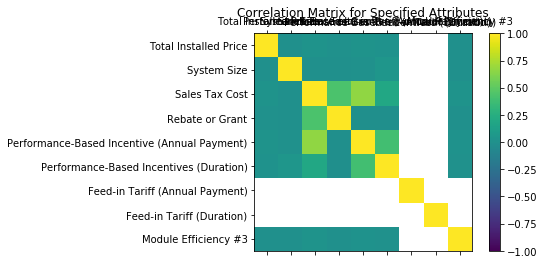

In [54]:
def plot_corr_matrix(correlations,attr,fig_no):
    fig=plt.figure(fig_no)
    ax=fig.add_subplot(111)
    ax.set_title("Correlation Matrix for Specified Attributes")
    ax.set_xticklabels(['']+attr)
    ax.set_yticklabels(['']+attr)
    cax=ax.matshow(correlations,vmax=1,vmin=-1)
    fig.colorbar(cax)
    plt.show()

plot_corr_matrix(corrmatrix, trackingDf_castd.columns, 334)

In [ ]:
sampledf = trackingDf_castd.sample(False, 0.1, 42)
sampledf.col('Total Installed Price')

In [ ]:
display(trackingDf_castd.sample(False, 0.2, 42))

In [ ]:
df_data_1.select('Module Efficiency #2').describe().show()

In [ ]:
df_data_1.select('Azimuth #1').show(10)